In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db import base_db_interface

raw_df = base_db_interface.read("bfo_espn_ufc_features")
for dt_col in ["Date", "DOB", "DOB_opp"]:
    raw_df[dt_col] = pd.to_datetime(raw_df[dt_col])
raw_df[["FighterOpen", "OpponentOpen"]] = raw_df[["FighterOpen", "OpponentOpen"]]\
    .astype(float)

raw_df = raw_df.drop_duplicates(subset=["FighterID_espn", "OpponentID_espn", "fight_id"])
raw_df["FighterID_espn"] = raw_df["FighterID_espn"].fillna("unknown")
raw_df["OpponentID_espn"] = raw_df["OpponentID_espn"].fillna("unknown")
print(raw_df.shape)
raw_df.head() # show the first 5 rows

(133102, 248)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,prev_weight,FighterID_espn_opp,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,2354059,0,0,0,NaN,0.0,185.0,185.0,NaN
1,1991-09-26_2354059_2558095,1991-09-26,W,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2558095,2354059,NaN,...,NaN,2558095,0,0,0,NaN,0.0,NaN,NaN,NaN
2,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,2501396,0,0,0,NaN,0.0,185.0,185.0,NaN
3,1992-01-01_2354119_2501396,1992-01-01,L,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2354119,2501396,NaN,...,NaN,2354119,0,0,0,NaN,0.0,170.0,170.0,NaN
4,1993-08-29_2354132_3107994,1993-08-29,W,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,3107994,2354132,NaN,...,NaN,3107994,0,0,0,NaN,0.0,NaN,NaN,NaN


In [4]:
df = raw_df.copy()

# Elo Alphas

Iterate over all elo alphas. Ignore PCA stuff for now

## Defining some targets for Elo estimators along the way

In [6]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

0.0    65262
1.0    65262
NaN     2578
Name: win_target, dtype: int64

In [7]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

0.0    45420
1.0    45420
NaN    42262
Name: win_target_finish, dtype: int64

In [8]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9891662033628346

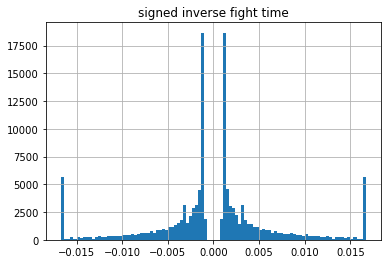

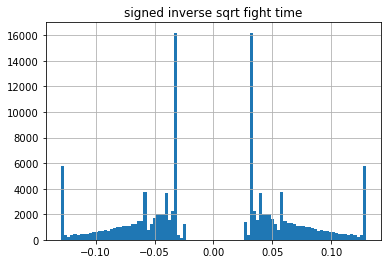

In [9]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)
plt.title("signed inverse fight time")
plt.show()

df["signed_inverse_sqrt_fight_time"].hist(bins=100)
plt.title("signed inverse sqrt fight time")
plt.show()

# Simpler features

In [16]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    assert (df["fight_id"].value_counts() == 2).all()
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    feat_df = df.sort_values("Date").copy()[[
        "fight_id", "FighterID_espn", "OpponentID_espn", "Date", "is_ufc"
    ]]
    # Rolling features over fighter_careers
    # because the data is doubled, we can simply group by the fighter id
    feat_df["dummy"] = 1
    # total fights
    feat_df["total_fights"] = feat_df.groupby("FighterID_espn")["dummy"].cumsum()
    feat_df["total_fights_opp"] = feat_df.groupby("OpponentID_espn")["dummy"].cumsum()
    # total ufc fights
    feat_df["total_ufc_fights"] = feat_df.groupby("FighterID_espn")["is_ufc"].cumsum()
    feat_df["total_ufc_fights_opp"] = feat_df.groupby("OpponentID_espn")["is_ufc"].cumsum()
    # time since last fight
    feat_df["t_since_last_fight"] = feat_df.groupby("FighterID_espn")["Date"].diff().dt.days
    feat_df["t_since_last_fight_opp"] = feat_df.groupby("OpponentID_espn")["Date"].diff().dt.days
    fill_val = 2*365 # arbitrarily say 2 years
    feat_df["t_since_last_fight"] = np.maximum(fill_val, feat_df["t_since_last_fight"].fillna(fill_val))   
    feat_df["t_since_last_fight_opp"] = np.maximum(fill_val, feat_df["t_since_last_fight_opp"].fillna(fill_val)) 
    # time since first fight
    feat_df["t_since_first_fight"] = (feat_df["Date"] - feat_df.groupby("FighterID_espn")["Date"].transform("min")).dt.days
    feat_df["t_since_first_fight_opp"] = (feat_df["Date"] - feat_df.groupby("OpponentID_espn")["Date"].transform("min")).dt.days
    # compute diffs
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    
    return feat_df

simple_feat_df = get_simple_features(df)
print(simple_feat_df.shape, df.shape)

(133102, 20) (133102, 259)


In [17]:
simple_feat_df.columns, df.columns

(Index(['fight_id', 'FighterID_espn', 'OpponentID_espn', 'Date', 'is_ufc',
        'dummy', 'total_fights', 'total_fights_opp', 'total_ufc_fights',
        'total_ufc_fights_opp', 't_since_last_fight', 't_since_last_fight_opp',
        't_since_first_fight', 't_since_first_fight_opp',
        't_since_last_fight_diff', 't_since_last_fight_log_diff',
        'total_fights_diff', 'total_fights_sqrt_diff', 'total_ufc_fights_diff',
        'total_ufc_fights_sqrt_diff'],
       dtype='object'),
 Index(['fight_id', 'Date', 'FighterResult', 'Decision', 'Rnd', 'Time', 'Event',
        'OpponentID_espn', 'FighterID_espn', 'TSL',
        ...
        'ordinal_fighter_result', 'submission_fighter_result',
        'tko_ko_fighter_result', 'decision_fighter_result',
        'finish_fighter_result', 'win_target_finish', 'fight_time',
        'signed_inverse_fight_time', 'signed_inverse_sqrt_fight_time',
        'signed_inverse_log_fight_time'],
       dtype='object', length=259))

In [18]:
feat_ml_df = df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "fight_id"],
    suffixes=("_legacy", ""),
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)
feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

# whether or not the fighter is from the USA
feat_ml_df["usa_diff"] = (
    feat_ml_df["Country"].str.strip().str.lower().str.contains("usa") -
    feat_ml_df["Country_opp"].str.strip().str.lower().str.contains("usa")
).fillna(0)

feat_ml_df["russia_diff"] = (
    feat_ml_df["Country"].str.strip().str.lower().str.contains("russia") -
    feat_ml_df["Country_opp"].str.strip().str.lower().str.contains("russia")
).fillna(0)

stance_fighter_clean = feat_ml_df["Stance"].fillna("orthodox").str.strip().str.lower()
stance_fighter_clean.loc[~stance_fighter_clean.isin(["southpaw", "switch"])] = "orthodox"
stance_opp_clean = feat_ml_df["Stance_opp"].fillna("orthodox").str.strip().str.lower()
stance_opp_clean.loc[~stance_opp_clean.isin(["southpaw", "switch"])] = "orthodox"

# advantage to fighter with the weirder stance
feat_ml_df["stance_diff"] = (
    (stance_fighter_clean == "southpaw") & (stance_opp_clean == "orthodox") |
    (stance_fighter_clean == "switch") & (stance_opp_clean == "orthodox")
).astype(int) - (
    (stance_fighter_clean == "orthodox") & (stance_opp_clean == "southpaw") |
    (stance_fighter_clean == "orthodox") & (stance_opp_clean == "switch")
).astype(int)

# new_feat_cols = [*feat_cols, "ml_logit"]
# feat_cols
feat_ml_df.columns

Index(['fight_id', 'Date_legacy', 'FighterResult', 'Decision', 'Rnd', 'Time',
       'Event', 'OpponentID_espn', 'FighterID_espn', 'TSL',
       ...
       'age_diff', 'log_reach_diff', 'weight_diff', 'height_diff',
       't_since_first_fight_diff', 'log_t_since_first_fight_diff',
       'log_t_since_prev_fight_diff', 'usa_diff', 'russia_diff',
       'stance_diff'],
      dtype='object', length=286)

In [19]:
feat_ml_df.columns[feat_ml_df.columns.str.contains("pred_")]

Index([], dtype='object')

# Model evaluation - predict errors of closing line

In [25]:
from wrangle.clean_bfo_data import parse_american_odds
from scipy.special import logit

close_df = base_db_interface.read("clean_bfo_close_data").rename(columns={
    "FighterID": "FighterID_bfo",
    "OpponentID": "OpponentID_bfo",
}).drop(columns=["FighterName", "OpponentName", "match_id"])
for market in "	DraftKings	BetMGM	Caesars	BetRivers	FanDuel	PointsBet	Unibet	Bet365	BetWay	5D	Ref".split():
    close_df[f"p_fighter_{market}_implied"] = parse_american_odds(close_df[f"{market}_fighter"])
    close_df[f"p_fighter_{market}_implied_logit"] = logit(close_df[f"p_fighter_{market}_implied"])

close_df.head()

feat_close_ml_df = feat_ml_df.merge(
    close_df,
    how="left",
    on=["FighterID_bfo", "OpponentID_bfo", "EventHref"],
)

In [26]:
feat_close_ml_df.loc[:, feat_close_ml_df.columns.str.contains("p_fighter")].isnull().mean()

p_fighter_open_implied                0.802460
p_fighter_close_implied               0.802460
p_fighter_DraftKings_implied          0.972795
p_fighter_DraftKings_implied_logit    0.972795
p_fighter_BetMGM_implied              0.976033
p_fighter_BetMGM_implied_logit        0.976033
p_fighter_Caesars_implied             0.976627
p_fighter_Caesars_implied_logit       0.976627
p_fighter_BetRivers_implied           0.984914
p_fighter_BetRivers_implied_logit     0.984914
p_fighter_FanDuel_implied             0.973637
p_fighter_FanDuel_implied_logit       0.973637
p_fighter_PointsBet_implied           0.988708
p_fighter_PointsBet_implied_logit     0.988708
p_fighter_Unibet_implied              0.979264
p_fighter_Unibet_implied_logit        0.979264
p_fighter_Bet365_implied              0.989865
p_fighter_Bet365_implied_logit        0.989865
p_fighter_BetWay_implied              0.954539
p_fighter_BetWay_implied_logit        0.954539
p_fighter_5D_implied                  0.814608
p_fighter_5D_

In [31]:
from scipy.special import expit, logit
from model.mma_features import BinaryEloErrorWrapper

# TODO need closing line odds for this to work

elo_feat_dict = dict()
for elo_alpha in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    print("curr elo_alpha: ", elo_alpha)
    binary_elo_target_cols = ["win_target", "win_target_finish"]
    elo_alphas = {
        col: elo_alpha for col in binary_elo_target_cols
    }
    bin_eew = BinaryEloErrorWrapper(elo_alphas=elo_alphas, 
                                    init_score_col="p_fighter_5D_implied_logit")
    bin_elo_error_feat_df = bin_eew.fit_transform_all(feat_close_ml_df)
    elo_feat_dict[elo_alpha] = bin_elo_error_feat_df

curr elo_alpha:  0.1
getting elo features for win_target


100%|██████████| 5194/5194 [00:07<00:00, 723.48it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 778.25it/s]


curr elo_alpha:  0.3
getting elo features for win_target


100%|██████████| 5194/5194 [00:07<00:00, 713.67it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 754.74it/s]


curr elo_alpha:  0.5
getting elo features for win_target


100%|██████████| 5194/5194 [00:06<00:00, 777.78it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 772.80it/s]


curr elo_alpha:  0.7
getting elo features for win_target


100%|██████████| 5194/5194 [00:06<00:00, 787.11it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 784.11it/s]


curr elo_alpha:  0.9
getting elo features for win_target


100%|██████████| 5194/5194 [00:06<00:00, 792.17it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 796.07it/s]


curr elo_alpha:  1.0
getting elo features for win_target


100%|██████████| 5194/5194 [00:06<00:00, 794.74it/s]


getting elo features for win_target_finish


100%|██████████| 5194/5194 [00:06<00:00, 794.95it/s]


In [32]:
elo_feat_close_ml_df = feat_close_ml_df.copy()

for k, v in elo_feat_dict.items():
    # convert probability to logit - better feature this way
    v[f"pred_elo_win_target_logit_{k}"] = logit(v["pred_elo_win_target"])
    v[f"pred_elo_win_target_finish_logit_{k}"] = logit(v["pred_elo_win_target_finish"])
    elo_feat_close_ml_df = elo_feat_close_ml_df.merge(
        v[[
            "FighterID_espn", "OpponentID_espn", "fight_id",
            f"pred_elo_win_target_logit_{k}", f"pred_elo_win_target_finish_logit_{k}"
        ]],
        on=["FighterID_espn", "OpponentID_espn", "fight_id"], 
        how="left"
    )
elo_feat_close_ml_df.columns[-20:]

Index(['p_fighter_Bet365_implied', 'p_fighter_Bet365_implied_logit',
       'p_fighter_BetWay_implied', 'p_fighter_BetWay_implied_logit',
       'p_fighter_5D_implied', 'p_fighter_5D_implied_logit',
       'p_fighter_Ref_implied', 'p_fighter_Ref_implied_logit',
       'pred_elo_win_target_logit_0.1', 'pred_elo_win_target_finish_logit_0.1',
       'pred_elo_win_target_logit_0.3', 'pred_elo_win_target_finish_logit_0.3',
       'pred_elo_win_target_logit_0.5', 'pred_elo_win_target_finish_logit_0.5',
       'pred_elo_win_target_logit_0.7', 'pred_elo_win_target_finish_logit_0.7',
       'pred_elo_win_target_logit_0.9', 'pred_elo_win_target_finish_logit_0.9',
       'pred_elo_win_target_logit_1.0',
       'pred_elo_win_target_finish_logit_1.0'],
      dtype='object')

In [33]:
feat_cols = [
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_prev_fight_diff",
    "log_t_since_first_fight_diff",
    "total_fights_diff",
#     "quad_log_t_since_first_fight_diff",
    "usa_diff",
    "russia_diff",
    "stance_diff",
    # "team_count_diff",

'pred_elo_win_target_logit_0.1', 'pred_elo_win_target_finish_logit_0.1',
       'pred_elo_win_target_logit_0.3', 'pred_elo_win_target_finish_logit_0.3',
       'pred_elo_win_target_logit_0.5', 'pred_elo_win_target_finish_logit_0.5',
       'pred_elo_win_target_logit_0.7', 'pred_elo_win_target_finish_logit_0.7',
       'pred_elo_win_target_logit_0.9', 'pred_elo_win_target_finish_logit_0.9',
       'pred_elo_win_target_logit_1.0',
       'pred_elo_win_target_finish_logit_1.0',
]
# TODO include binary elo error features

In [34]:
# checking to see how much data we have for each feature
elo_feat_close_ml_df[feat_cols].notnull().sum()

age_diff                                133102
log_reach_diff                          133102
weight_diff                             133102
height_diff                             133102
log_t_since_prev_fight_diff             133102
log_t_since_first_fight_diff            133102
total_fights_diff                       133102
usa_diff                                133102
russia_diff                             133102
stance_diff                             133102
pred_elo_win_target_logit_0.1            24676
pred_elo_win_target_finish_logit_0.1     24676
pred_elo_win_target_logit_0.3            24676
pred_elo_win_target_finish_logit_0.3     24676
pred_elo_win_target_logit_0.5            24676
pred_elo_win_target_finish_logit_0.5     24676
pred_elo_win_target_logit_0.7            24676
pred_elo_win_target_finish_logit_0.7     24676
pred_elo_win_target_logit_0.9            24676
pred_elo_win_target_finish_logit_0.9     24676
pred_elo_win_target_logit_1.0            24676
pred_elo_win_

In [35]:
print(elo_feat_close_ml_df.shape)
elo_feat_close_ml_df = elo_feat_close_ml_df.drop_duplicates(subset=["fight_id"])
print(elo_feat_close_ml_df[feat_cols].notnull().sum())
elo_feat_close_ml_df.shape

(133102, 342)
age_diff                                66551
log_reach_diff                          66551
weight_diff                             66551
height_diff                             66551
log_t_since_prev_fight_diff             66551
log_t_since_first_fight_diff            66551
total_fights_diff                       66551
usa_diff                                66551
russia_diff                             66551
stance_diff                             66551
pred_elo_win_target_logit_0.1           12334
pred_elo_win_target_finish_logit_0.1    12334
pred_elo_win_target_logit_0.3           12334
pred_elo_win_target_finish_logit_0.3    12334
pred_elo_win_target_logit_0.5           12334
pred_elo_win_target_finish_logit_0.5    12334
pred_elo_win_target_logit_0.7           12334
pred_elo_win_target_finish_logit_0.7    12334
pred_elo_win_target_logit_0.9           12334
pred_elo_win_target_finish_logit_0.9    12334
pred_elo_win_target_logit_1.0           12334
pred_elo_win_target_

(66551, 342)

# Closing line performance - 5Dimes

Using 5Dimes because it has the most historical data

In [36]:
# p_fighter_implied_col = "p_fighter_open_implied"
p_fighter_implied_col = f"p_fighter_5D_implied"

In [37]:
from model.mma_log_reg_stan import SimpleSymmetricModel

mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

In [38]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col=p_fighter_implied_col)
preds_df = tscv.get_cross_val_preds(
    mod, 
    elo_feat_close_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -17669.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5798.17    0.00293598       11.6697      0.6192      0.6192       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -5793.11    0.00499534       4.32782           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -5792.11    0.00701364       2.10672           1           1       70   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79      -5791.31     0.0240338         13.57      0.2477      0.2477       92   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -5790.87     0.0289301       4.02798      0.5135           1      115   
    Iter      log 

In [39]:
mod_pred = preds_df["y_pred"].round()
ml_pred = preds_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == preds_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == preds_df["win_target"]).mean())

Model accuracy:      0.7117358322177599
Moneyline accuracy:  0.6987951807228916


In [40]:
from sklearn.metrics import log_loss

xce = log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])
xce_ml = log_loss(y_true=preds_df["win_target"], y_pred=preds_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Moneyline log loss: {xce_ml}")

model log loss    : 0.5588350709504628
Moneyline log loss: 0.5733131540431888


In [41]:
list(zip(mod.feat_cols, mod.fit['beta']))

[('age_diff', 0.18847743821295448),
 ('log_reach_diff', 0.03421987836433236),
 ('weight_diff', 0.008884527079380975),
 ('height_diff', 0.009247770294353768),
 ('log_t_since_prev_fight_diff', -0.14853415993857352),
 ('log_t_since_first_fight_diff', 0.2135858624115087),
 ('total_fights_diff', 0.04022146749388865),
 ('usa_diff', -0.039598717693166426),
 ('russia_diff', 0.04806593819017256),
 ('stance_diff', 0.07144636300610253),
 ('pred_elo_win_target_logit_0.1', -0.012557701361101724),
 ('pred_elo_win_target_finish_logit_0.1', -0.09706533736389673),
 ('pred_elo_win_target_logit_0.3', 0.16608040896193735),
 ('pred_elo_win_target_finish_logit_0.3', -0.13049995845425363),
 ('pred_elo_win_target_logit_0.5', 0.29722032339899507),
 ('pred_elo_win_target_finish_logit_0.5', -0.11692153234604892),
 ('pred_elo_win_target_logit_0.7', 0.22906286900081377),
 ('pred_elo_win_target_finish_logit_0.7', -0.05652921637030961),
 ('pred_elo_win_target_logit_0.9', -0.07694684724555224),
 ('pred_elo_win_target

In [42]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week

In [49]:
from model_selection.backtesting import MultiKellyPortfolioManager, TradingSimulator

# fighter_ml_col = "FanDuel_fighter"
# opponent_ml_col = "FanDuel_opponent"
fighter_ml_col = "5D_fighter"
opponent_ml_col = "5D_opponent"

kwargs = {
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}
preds_df[fighter_ml_col] = preds_df[fighter_ml_col].str.replace("▼", "").str.replace("▲", "")
preds_df[opponent_ml_col] = preds_df[opponent_ml_col].str.replace("▼", "").str.replace("▲", "")

kelly_pm = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts = TradingSimulator(kelly_pm, **kwargs)
ts.simulate_trading(preds_df, bet_ts_col="Date", payout_ts_col="Date")
ts.returns_df

100%|██████████| 224/224 [00:03<00:00, 74.47it/s]


,fight_id,FighterID_espn,OpponentID_espn,5D_fighter,5D_opponent,fighter_dec_odds,opponent_dec_odds,p_fighter_rf,p_opponent_rf,fighter_stake,...,p_bankroll_opponent,fighter_possible_collect,opponent_possible_collect,win_target,y_pred,fight_profit,fighter_profit,opponent_profit,Date,final_portfolio_value
0,2021-01-16_2614933_3164030,3164030,2614933,+135,-155,2.350000,1.645161,0.425532,0.607843,0.001073,...,0.0,0.002521,0.0,0.0,0.430463,-0.001073,-0.001073,0.000000,2021-01-16,0.981914
1,2021-01-16_4065639_4397782,4065639,4397782,-108,-112,1.925926,1.892857,0.519231,0.528302,0.0,...,0.0,0.0,0.0,0.0,0.478391,0.000000,0.000000,0.000000,2021-01-16,0.981914
2,2021-01-16_4257695_4566145,4566145,4257695,+160,-185,2.600000,1.540541,0.384615,0.649123,0.0,...,0.007645,0.0,0.011777,0.0,0.329418,0.004132,0.000000,0.004132,2021-01-16,0.981914
3,2021-01-16_4354426_4570669,4354426,4570669,+200,-240,3.000000,1.416667,0.333333,0.705882,0.004953,...,0.0,0.014858,0.0,0.0,0.359748,-0.004953,-0.004953,0.000000,2021-01-16,0.981914
4,2021-01-16_3010042_3161786,3010042,3161786,-300,+250,1.333333,3.500000,0.750000,0.285714,0.037398,...,0.0,0.049865,0.0,1.0,0.824797,0.012466,0.012466,0.000000,2021-01-16,0.981914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236,2023-03-25_3041138_5077398,3041138,5077398,-170,+140,1.588235,2.400000,0.629630,0.416667,0.0,...,0.012257,0.0,0.886423,0.0,0.540432,0.517080,0.000000,0.517080,2023-03-25,30.008688
2237,2023-03-25_2959422_3088682,2959422,3088682,-185,+155,1.540541,2.550000,0.649123,0.392157,0.0,...,0.0,0.0,0.0,0.0,0.619211,0.000000,0.000000,0.000000,2023-03-25,30.008688
2238,2023-03-25_4713584_4869425,4713584,4869425,-110,-120,1.909091,1.833333,0.523810,0.545455,0.0,...,0.00139,0.0,0.076808,1.0,0.450753,-0.041895,0.000000,-0.041895,2023-03-25,30.008688
2239,2023-03-25_3155424_4294504,3155424,4294504,+130,-160,2.300000,1.625000,0.434783,0.615385,0.154243,...,0.0,0.354758,0.0,0.0,0.452142,-0.154243,-0.154243,0.000000,2023-03-25,30.008688


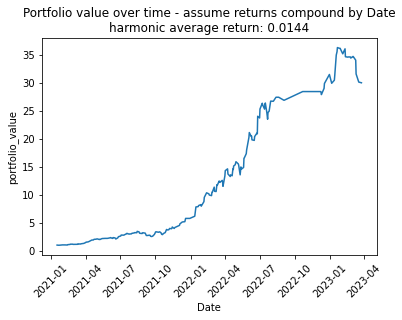

In [50]:
ts.plot_diagnostics()

In [51]:
# n = ts.returns_df.shape[0]
ts.returns_df["fight_profit"].mean() / (ts.returns_df["fight_profit"].std() / np.sqrt(ts.returns_df.shape[0]))

3.2058246242831396

100%|██████████| 171/171 [00:02<00:00, 76.65it/s]


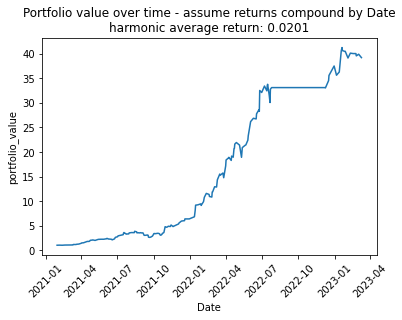

In [52]:
kelly_pm0 = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts0 = TradingSimulator(kelly_pm0, **kwargs)
ts0.simulate_trading(preds_df.query("is_ufc == 0"), bet_ts_col="Date", payout_ts_col="Date")
ts0.plot_diagnostics()

100%|██████████| 88/88 [00:01<00:00, 75.51it/s]


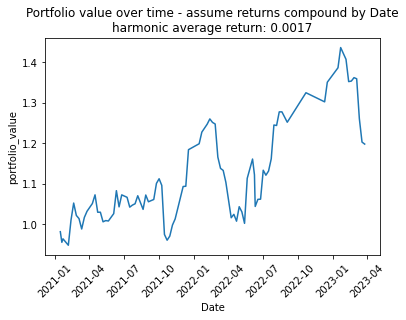

In [53]:
kelly_pm1 = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts1 = TradingSimulator(kelly_pm1, **kwargs)
ts1.simulate_trading(preds_df.query("is_ufc == 1"), bet_ts_col="Date", payout_ts_col="Date")
ts1.plot_diagnostics()

# Closing moneyline - FanDuel

Still using a model to predict the 5Dimes closing moneylines' errors. So I don't expect this to perform terribly well

In [54]:
from model_selection.backtesting import MultiKellyPortfolioManager, TradingSimulator

fighter_ml_col = "FanDuel_fighter"
opponent_ml_col = "FanDuel_opponent"

kwargs = {
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}
preds_df[fighter_ml_col] = preds_df[fighter_ml_col].str.replace("▼", "").str.replace("▲", "")
preds_df[opponent_ml_col] = preds_df[opponent_ml_col].str.replace("▼", "").str.replace("▲", "")

kelly_pm = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts = TradingSimulator(kelly_pm, **kwargs)
ts.simulate_trading(preds_df, bet_ts_col="Date", payout_ts_col="Date")
ts.returns_df

100%|██████████| 224/224 [00:03<00:00, 74.19it/s]


,fight_id,FighterID_espn,OpponentID_espn,FanDuel_fighter,FanDuel_opponent,fighter_dec_odds,opponent_dec_odds,p_fighter_rf,p_opponent_rf,fighter_stake,...,p_bankroll_opponent,fighter_possible_collect,opponent_possible_collect,win_target,y_pred,fight_profit,fighter_profit,opponent_profit,Date,final_portfolio_value
0,2021-01-16_2614933_3164030,3164030,2614933,None,None,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.0,0.430463,0.000000,0.000000,0.000000,2021-01-16,1.000000
1,2021-01-16_4065639_4397782,4065639,4397782,None,None,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.0,0.478391,0.000000,0.000000,0.000000,2021-01-16,1.000000
2,2021-01-16_4257695_4566145,4566145,4257695,None,None,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.0,0.329418,0.000000,0.000000,0.000000,2021-01-16,1.000000
3,2021-01-16_4354426_4570669,4354426,4570669,None,None,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.0,0.359748,0.000000,0.000000,0.000000,2021-01-16,1.000000
4,2021-01-16_3010042_3161786,3010042,3161786,None,None,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,1.0,0.824797,0.000000,0.000000,0.000000,2021-01-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236,2023-03-25_3041138_5077398,3041138,5077398,-164,+138,1.609756,2.380000,0.621212,0.420168,0.0,...,0.011325,0.0,0.043204,0.0,0.540432,0.025051,0.000000,0.025051,2023-03-25,1.602455
2237,2023-03-25_2959422_3088682,2959422,3088682,-162,+134,1.617284,2.340000,0.618321,0.427350,0.000623,...,0.0,0.001008,0.0,0.0,0.619211,-0.000623,-0.000623,0.000000,2023-03-25,1.602455
2238,2023-03-25_4713584_4869425,4713584,4869425,-104,-112,1.961538,1.892857,0.509804,0.528302,0.0,...,0.0074,0.0,0.022453,1.0,0.450753,-0.011862,0.000000,-0.011862,2023-03-25,1.602455
2239,2023-03-25_3155424_4294504,3155424,4294504,+116,-136,2.160000,1.735294,0.462963,0.576271,0.0,...,0.0,0.0,0.0,0.0,0.452142,0.000000,0.000000,0.000000,2023-03-25,1.602455


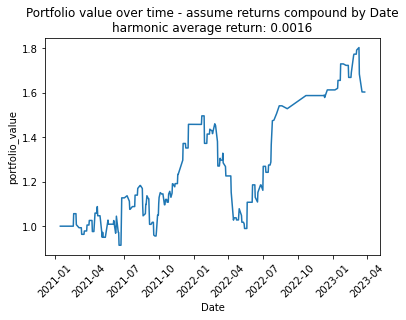

In [55]:
ts.plot_diagnostics()

is_ufc == 0


100%|██████████| 171/171 [00:02<00:00, 78.52it/s]


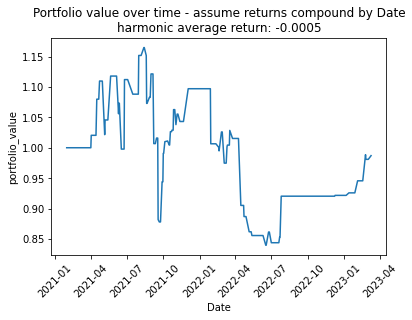

is_ufc == 1


100%|██████████| 88/88 [00:01<00:00, 73.81it/s]


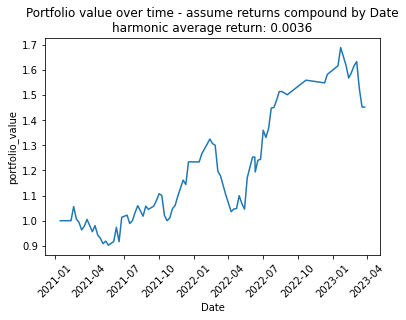

In [59]:
print("is_ufc == 0")
kelly_pm0 = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts0 = TradingSimulator(kelly_pm0, **kwargs)
ts0.simulate_trading(preds_df.query("is_ufc == 0"), bet_ts_col="Date", payout_ts_col="Date")
ts0.plot_diagnostics()

print("is_ufc == 1")
kelly_pm1 = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts1 = TradingSimulator(kelly_pm1, **kwargs)
ts1.simulate_trading(preds_df.query("is_ufc == 1"), bet_ts_col="Date", payout_ts_col="Date")
ts1.plot_diagnostics()